In [1]:
import os
os.environ['JAX_PLATFORMS'] = 'cpu'


import jax
import jax.numpy as jnp

from jax import config
config.update("jax_enable_x64", True)

In [2]:
from LIMxCMBL.init import *
from LIMxCMBL.kernels import *
from LIMxCMBL.experiments import *

from scipy.interpolate import interp1d, LinearNDInterpolator
from scipy.integrate import quad, quad_vec, trapezoid, qmc_quad
from scipy.stats import qmc

from tqdm import trange

In [3]:
_tmp_ks = np.logspace(-10, 5, 100000)
_tmp_Pk = np.zeros_like(_tmp_ks)

for k_idx, k in enumerate(_tmp_ks):
    _tmp_Pk[k_idx] = ccl.linear_matter_power(cosmo, k, 1)
    
n_bins = 100


_ells = jnp.logspace(1, np.log10(5000), 100)
_ells = _ells.reshape(-1,1)

In [4]:
experiment = 'COMAP'
Lambda_idx = 24

In [5]:
kernels = {}
kernels['CII'] = np.array(KI)
kernels['CO'] = np.array(KI_CO)
kernels['Lya'] = np.array(KI_Lya)
kernels['HI'] = np.array(KI_HI)

In [6]:
import matplotlib.pyplot as plt

/scratch/users/delon/LIMxCMBL/IHiKappa/CCAT-prime_LIMBER_IHik_idx_-1.npy


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


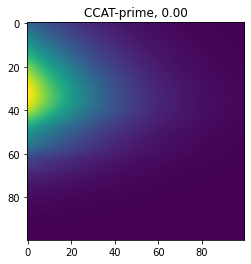

/scratch/users/delon/LIMxCMBL/IHiKappa/CCAT-prime_LIMBER_IHik_idx_18.npy


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


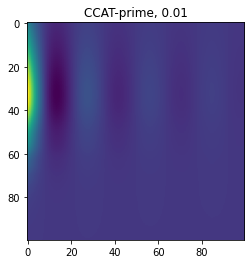

/scratch/users/delon/LIMxCMBL/IHiKappa/CCAT-prime_LIMBER_IHik_idx_24.npy


100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


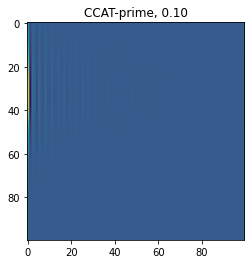

/scratch/users/delon/LIMxCMBL/IHiKappa/COMAP_LIMBER_IHik_idx_-1.npy


100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


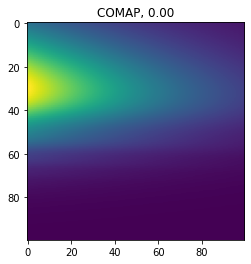

/scratch/users/delon/LIMxCMBL/IHiKappa/COMAP_LIMBER_IHik_idx_18.npy


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


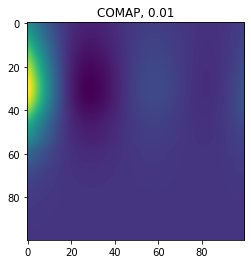

/scratch/users/delon/LIMxCMBL/IHiKappa/COMAP_LIMBER_IHik_idx_24.npy


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


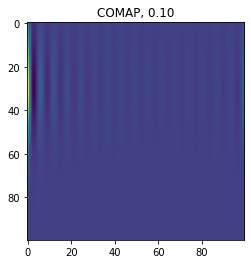

/scratch/users/delon/LIMxCMBL/IHiKappa/SPHEREx_LIMBER_IHik_idx_-1.npy


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


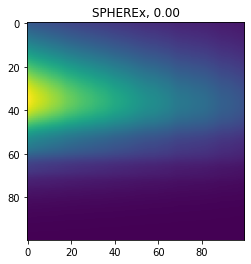

/scratch/users/delon/LIMxCMBL/IHiKappa/SPHEREx_LIMBER_IHik_idx_18.npy


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


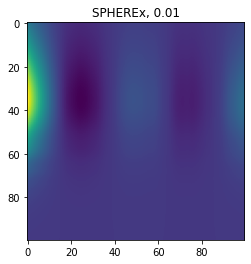

/scratch/users/delon/LIMxCMBL/IHiKappa/SPHEREx_LIMBER_IHik_idx_24.npy


100%|██████████| 100/100 [01:03<00:00,  1.56it/s]


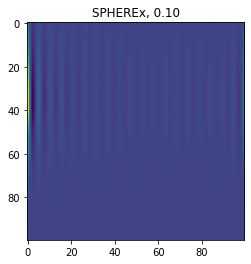

/scratch/users/delon/LIMxCMBL/IHiKappa/HETDEX_LIMBER_IHik_idx_-1.npy


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


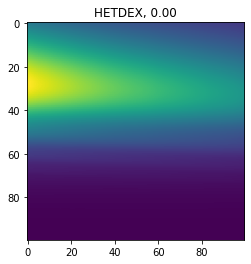

/scratch/users/delon/LIMxCMBL/IHiKappa/HETDEX_LIMBER_IHik_idx_18.npy


100%|██████████| 100/100 [01:04<00:00,  1.54it/s]


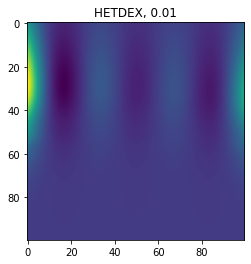

/scratch/users/delon/LIMxCMBL/IHiKappa/HETDEX_LIMBER_IHik_idx_24.npy


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


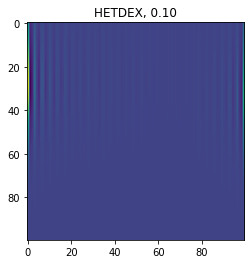

/scratch/users/delon/LIMxCMBL/IHiKappa/CHIME_LIMBER_IHik_idx_-1.npy


100%|██████████| 100/100 [01:05<00:00,  1.54it/s]


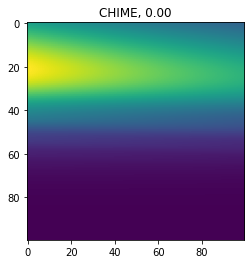

/scratch/users/delon/LIMxCMBL/IHiKappa/CHIME_LIMBER_IHik_idx_19.npy


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


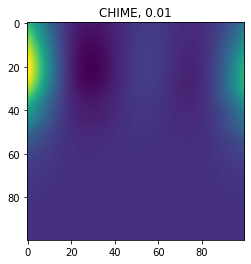

/scratch/users/delon/LIMxCMBL/IHiKappa/CHIME_LIMBER_IHik_idx_24.npy


100%|██████████| 100/100 [01:06<00:00,  1.50it/s]


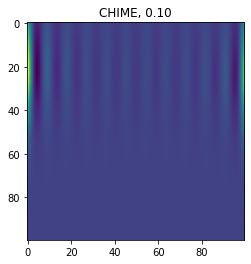

In [7]:
for experiment in experiments:
    _LIDXs = [-1, 18, 24]
    if(experiment == 'CHIME'):
        _LIDXs =  [-1, 19, 24] #first one above fundamental
    for Lambda_idx in _LIDXs:
        oup_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/'
        oup_fname += '%s_LIMBER_IHik_idx_%d.npy'%(experiment, Lambda_idx, )
        print(oup_fname)

        zmin = experiments[experiment]['zmin']
        zmax = experiments[experiment]['zmax']

        line_str = experiments[experiment]['line_str']


        chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
        chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

        chi_bin_edges = np.linspace(chimin*(1+1e-8), chimax*(1 - 1e-8), n_bins + 1)
        chi_bin_centers = (chi_bin_edges[1:] + chi_bin_edges[:-1])/2
        dchi_binned = np.mean(np.diff(chi_bin_edges))


        Lambda = 0.0
        if(Lambda_idx >= 0):
            Lambda = Lambdas[Lambda_idx]

        __KI = kernels[line_str]
        _KI = np.where(((chis >= chimin) & (chis <= chimax)), __KI, 0)

        @jax.jit
        def f_unfiltered_integrand(chi):
            return (1/chi**2 
                    * jnp.interp(x = chi, xp = chis, fp = _KI, left = 0, right = 0)
                    * jnp.interp(x = chi, xp = chis, fp = Wk*Dz, left = 0, right = 0)
                    * jnp.interp(x = jnp.log((_ells+1/2)/chi), 
                                 xp = jnp.log(_tmp_ks), 
                                 fp = _tmp_Pk, left = 0, right = 0))

        @jax.jit
        def _f_filtered_integrand(chi, _chib):
            return (1/_chib**2 
                    * jnp.interp(x = _chib, xp = chis, fp = _KI, left = 0, right = 0)
                    * Lambda / jnp.pi*jnp.sinc(Lambda * (_chib - chi) / np.pi)
                    * jnp.interp(x = chi, xp = chis, fp = Wk*Dz, left = 0, right = 0)
                    * jnp.interp(x = jnp.log((_ells+1/2)/_chib), 
                                 xp = jnp.log(_tmp_ks), 
                                 fp = _tmp_Pk, left = 0, right = 0))

        @jax.jit
        def f_filtered_integrand(x):
            chi, _chib = x[0], x[1]

            chi = chi.reshape(1, -1)
            _chib = _chib.reshape(1, -1)

            return  _f_filtered_integrand(chi=chi, _chib=_chib)

        #do integral
        IHi_kappa = np.zeros((len(ells), n_bins))
        for chi_idx in trange(n_bins):
            qrng = qmc.Halton(d = 2)

            l, r = chi_bin_edges[chi_idx], chi_bin_edges[chi_idx+1]

            def _rng_spawn(rng, n_children):
                bg = rng._bit_generator
                ss = bg._seed_seq
                child_rngs = [np.random.Generator(type(bg)(child_ss))
                              for child_ss in ss.spawn(n_children)]
                return child_rngs

            n_estimates = 2**3
            n_points = 2**13
            estimates = np.zeros((n_estimates, 100))

            rngs = _rng_spawn(qrng.rng, n_estimates)

            for i in range(n_estimates):
                sample = qrng.random(n = n_points)
                sample_bin = sample[:, -1]

                _chis = qmc.scale(jnp.array([sample_bin]), l, r)
                estimates[i] = jnp.mean(f_unfiltered_integrand(_chis), axis = -1)

                a = np.array([l, chimin,])
                b = np.array([r, chimax,])

                #only worry about measure for dchib integral
                #since we want averages in chi bins
                dA = (chimax - chimin) / n_points

                x = jnp.array(qmc.scale(sample, a, b)).T
                estimates[i] -= jnp.sum(f_filtered_integrand(x) * dA, axis = -1)


                qrng = type(qrng)(seed=rngs[i], **qrng._init_quad)


            integral = jnp.mean(estimates, axis=0)
            standard_error = jnp.std(estimates, axis = 0, ddof = 1)
            IHi_kappa[:, chi_idx] = integral

        jnp.save(oup_fname, IHi_kappa)
        plt.imshow(IHi_kappa)
        plt.title('%s, %.2f'%(experiment, Lambda))
        plt.show()